In [1]:
%pylab notebook
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
pathout = "../figures/" + "colin_marcelo_sed/"
! mkdir $pathout

mkdir: ../figures/colin_marcelo_sed/: File exists


In [4]:
h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1

# Moment expansion for a modified black body spectra
def y1(x):
    return x*exp(x)/(exp(x)-1.)

def y2(x):
    return y1(x)*x*cosh(0.5*x)/sinh(0.5*x)

def y3(x):
    return y1(x)*x*x*(cosh(x)+2)/(cosh(x)-1)

def y4(x):
    return y2(x)*0.5*x*x*(cosh(x)+5)/(sinh(0.5*x)**2.)

def y5(x):
    return y1(x)*(x**4.)*(33.+26*cosh(x)+cosh(2.*x))/(8.*sinh(0.5*x)**4.)

def f_mbb(nu,T,alpha,A,p22,p23,p33,p222,p223,p233,p333,p2222):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + 0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. + 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) + p333*y3(x)/6.)
    temp = temp +  I0*(p2222*(log(nu/nu0)**4.)/24.)
    return temp

<IPython.core.display.Javascript object>


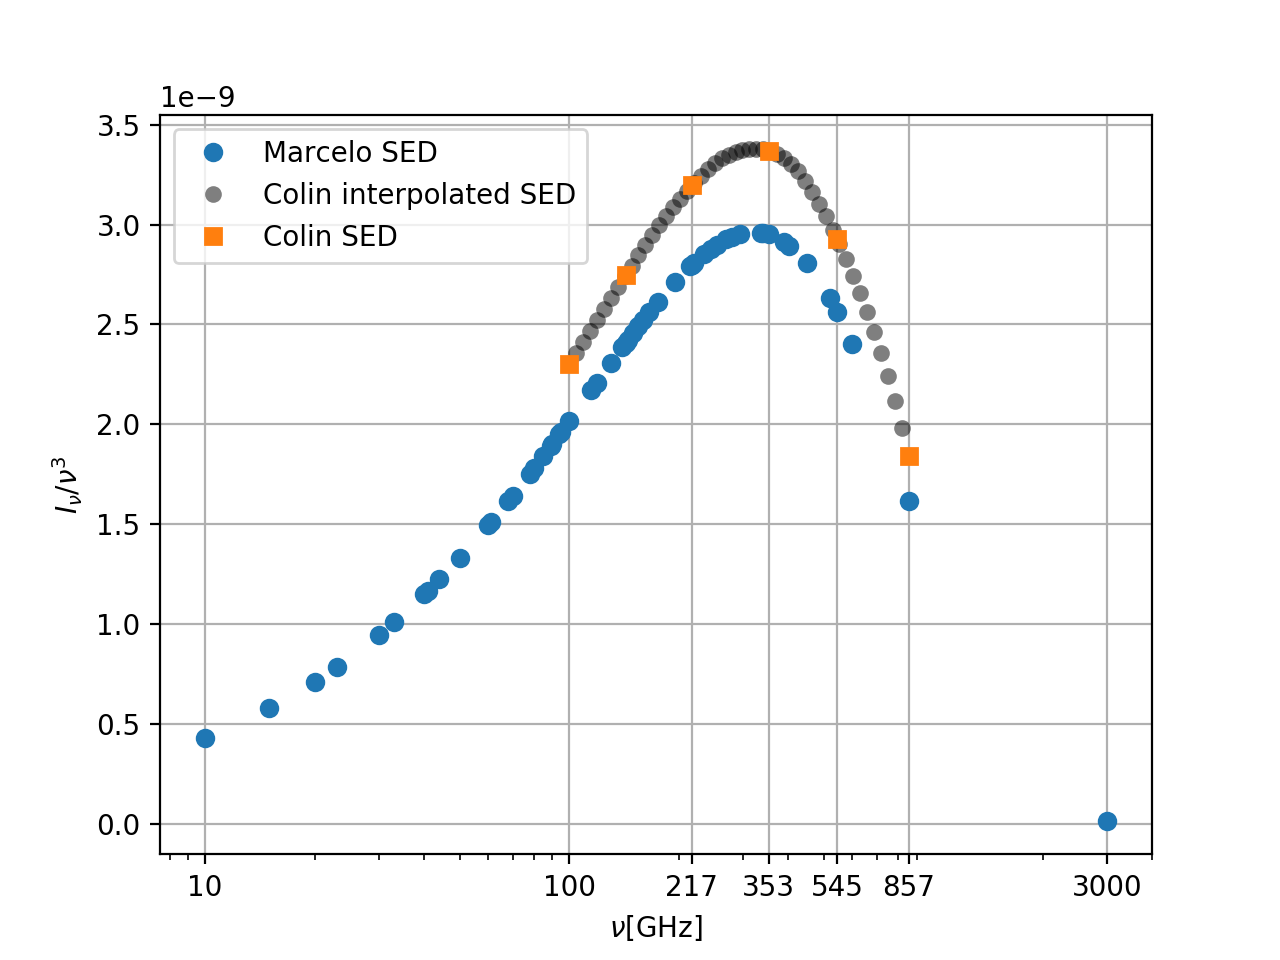

In [5]:
dc=loadtxt("../data/colin_data.txt")
dm=loadtxt("../data/marcelo_data.txt")
nu=dc[:,0]
Inu=dc[:,1]

sigma=zeros(size(nu),float)
nu=logspace(log10(min(dc[:,0])),log10(max(dc[:,0])),50)
fn=interp1d(dc[:,0],dc[:,1]/(dc[:,0]**3.),kind="quadratic")
Inu=log(fn(nu))
Inu=fn(nu)*(nu**3.)


figure()
plot(dm[:,0],dm[:,1]/(dm[:,0]**3),"o",label="Marcelo SED")
plot(nu,Inu/(nu**3.),"ko",mec="none",alpha=0.5,label="Colin interpolated SED")
plot(dc[:,0],dc[:,1]/(dc[:,0]**3),"s",label="Colin SED")
ylabel(r"$I_{\nu}/ \nu^{3}$")
xlabel(r"$\nu$[GHz]")
#axvline(900,color="black",linestyle="dashed")
semilogx()
legend(loc=0)
grid()
xticks([10,100,217,353,545,857,3000],[10,100,217,353,545,857,3000])
savefig(pathout + "intensity_spectrum_data.pdf",dpi=150,bbox_inches="tight",alpha=0.3)
savefig(pathout + "intensity_spectrum_data.jpeg",dpi=150,bbox_inches="tight",alpha=0.3)

# Analysis on SED's provided by Colin

In [7]:
nu=dc[:,0]
Inu=dc[:,1]

sigma=zeros(size(nu),float)
nu=logspace(log10(min(dc[:,0])),log10(max(dc[:,0])),50)
fn=interp1d(dc[:,0],dc[:,1]/(dc[:,0]**3.),kind="quadratic")
Inu=log(fn(nu))
Inu=fn(nu)*(nu**3.)

p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.), nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=2.
p0=(5.,1.,1.,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.), nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

#p0=append(fitp1,(0.,0.,0.,0.))
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0)
lb=append(lb1,[-prange,-prange,-prange,-prange,-prange])
ub=append(ub1,[prange,prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333,p2222: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333,p2222), nu,Inu,p0,maxfev=200000)
print fitp2

[  1.29927201e+01   1.74411852e+00   5.64592384e-09]
[  6.25358162e+00   2.65829140e+00   2.16575289e-09   2.00000000e+00
  -1.07280483e+00   5.91462075e-01]
[  5.64395516e+00   2.13043246e+00   5.88180881e-09   4.65543227e+00
   1.81167453e-02  -4.63077050e-01  -2.83980322e-01  -2.25814164e+00
   3.12701610e-02   3.02746122e-01   3.10030601e+01]


<IPython.core.display.Javascript object>


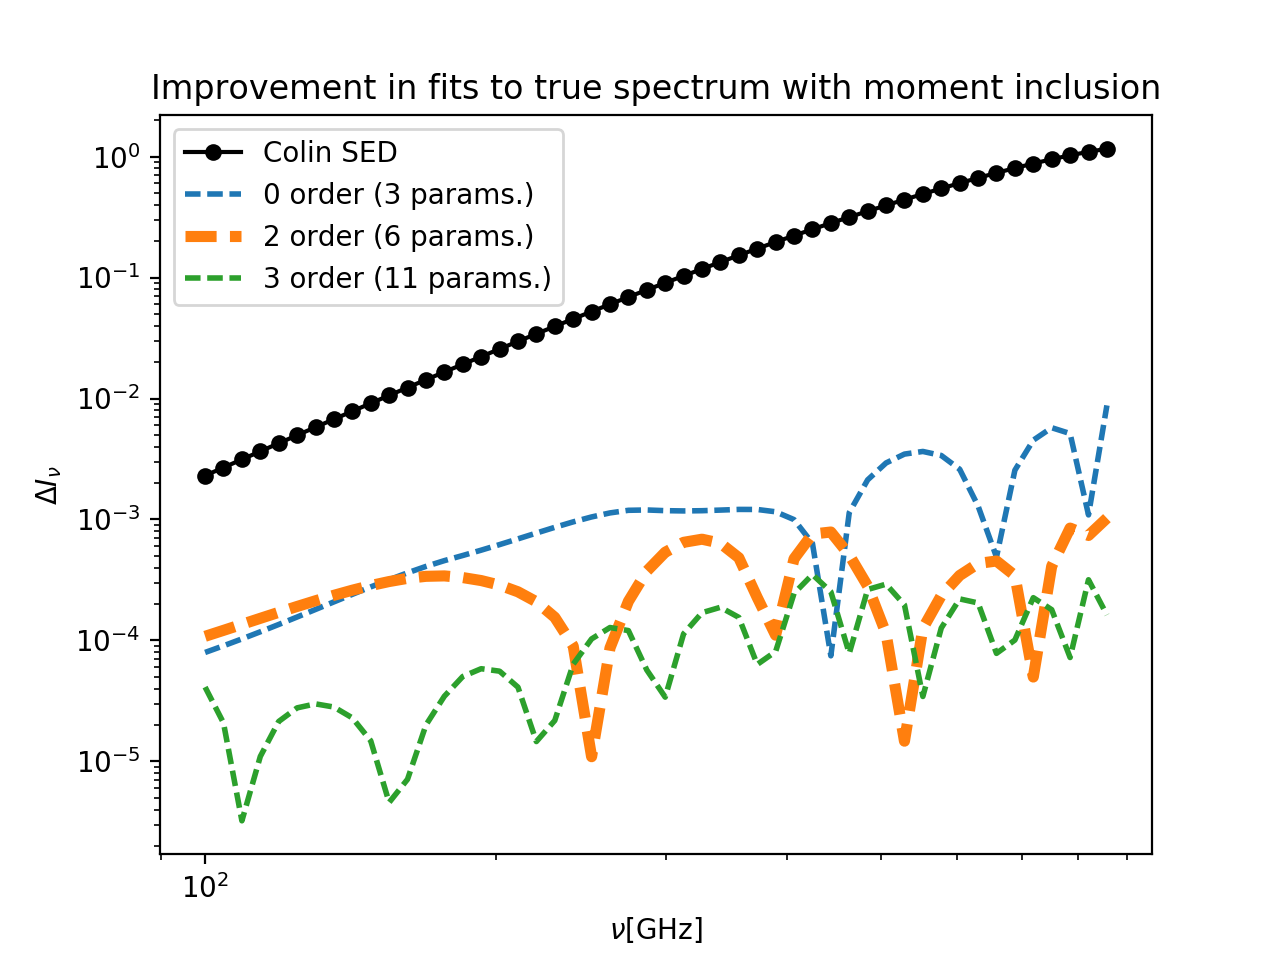

<IPython.core.display.Javascript object>


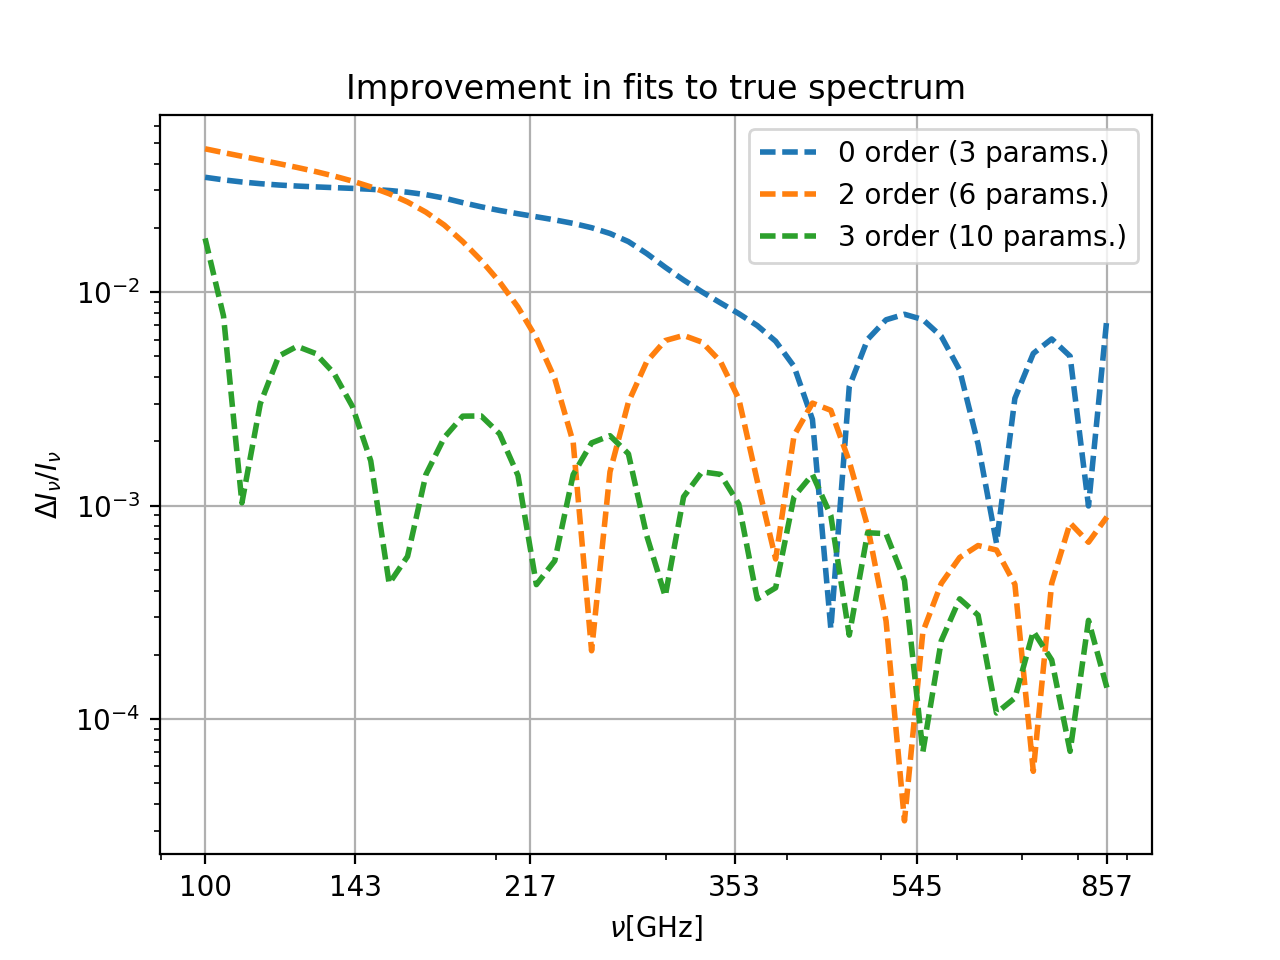

<IPython.core.display.Javascript object>


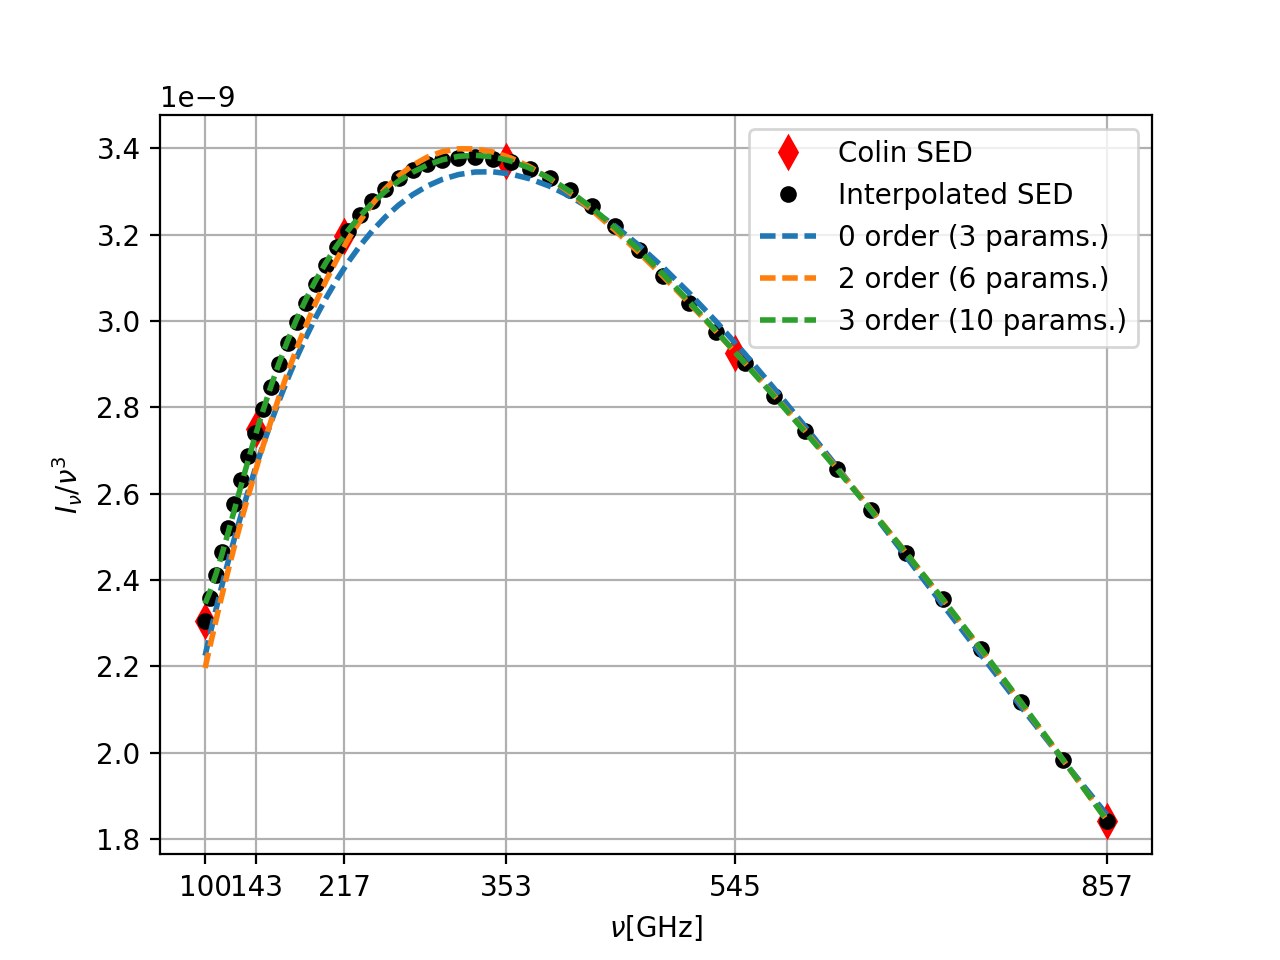

In [8]:
figure()
title("Improvement in fits to true spectrum with moment inclusion")
plot(nu,Inu,"ko-",mec="none",label="Colin SED")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)),"--",lw=4,label=pllabel)
pllabel="3 order (11 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10])),"--",lw=2,label=pllabel)
semilogy()
loglog()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
legend(loc=0)
savefig(pathout + "improvement_in_fits_colin_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "improvement_in_fits_colin_sed.jpeg",dpi=150,bbox_inches="tight")

figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$\Delta I_{\nu}/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
xticks([100,143,217,353,545,857],[100,143,217,353,545,857])
grid()
#ylim(1e-5,1e-1)
legend(loc=0)
savefig(pathout + "relative_error_with_taylor_order_colin_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order_colin_sed.jpeg",dpi=150,bbox_inches="tight")


figure()
sl=3.
title("")
plot(dc[:,0],dc[:,1]/(dc[:,0]**sl),"rd",ms=8,label="Colin SED")
pllabel="Interpolated SED"
plot(nu,Inu/(nu**sl),"ko",mec="none",lw=4,alpha=1.,label=pllabel)
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
ylabel(r"$I_{\nu}/ \nu^{3}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,143,217,353,545,857],[100,143,217,353,545,857])
savefig(pathout + "inu_fit_with_taylor_order_colin_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "inu_fit_with_taylor_order_colin_sed.jpeg",dpi=150,bbox_inches="tight")

# Analysis on SED's provided by Marcelo

In [11]:
nu=dm[:,0]#[dm[:,0]<1000.]
Inu=dm[:,1]#[dm[:,0]<1000.] 


p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(lambda x, T, alpha, A: f_mbb(x, T, alpha, A, p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.), nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

prange=1.
p0=(10.,1.,1e-6,0.,0.,0.)
lb1=append(lb0,[-prange,-prange,-prange])
ub1=append(ub0,[prange,prange,prange])
fitp1, fitcov1=curve_fit(lambda x, T, alpha, A, p22, p23, p33: f_mbb(x, T, alpha, A, p22, p23,p33,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.), nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

#p0=append(fitp1,(0.,0.,0.,0.))
p0=(5.,1.,1.,0.,0.,0.,0.,0.,0.,0.,0.)
lb=append(lb1,[-prange,-prange,-prange,-prange,-prange])
ub=append(ub1,[prange,prange,prange,prange,prange])
fitp2, fitcov2=curve_fit(lambda x, T, alpha, A, p22, p23, p33, p222,p223,p233,p333,p2222: f_mbb(x, T, alpha, A, p22, p23,p33,p222,p223,p233,p333,p2222), nu,Inu,p0,maxfev=200000)
print fitp2

[  1.65052608e+01   1.35926308e+00   5.21474100e-09]
[  1.74326006e+01  -1.37303651e-01   6.69005219e-09   5.83039869e-01
   8.49067566e-01  -1.36034516e-01]
[  1.49961617e+01   7.51376867e-01   2.69516120e-09   2.30894530e+00
   4.72572501e-01   5.18201688e-01   2.76192752e-01  -1.94238631e+00
   2.12332255e-01   1.09846069e-04   1.52570064e-01]


<IPython.core.display.Javascript object>


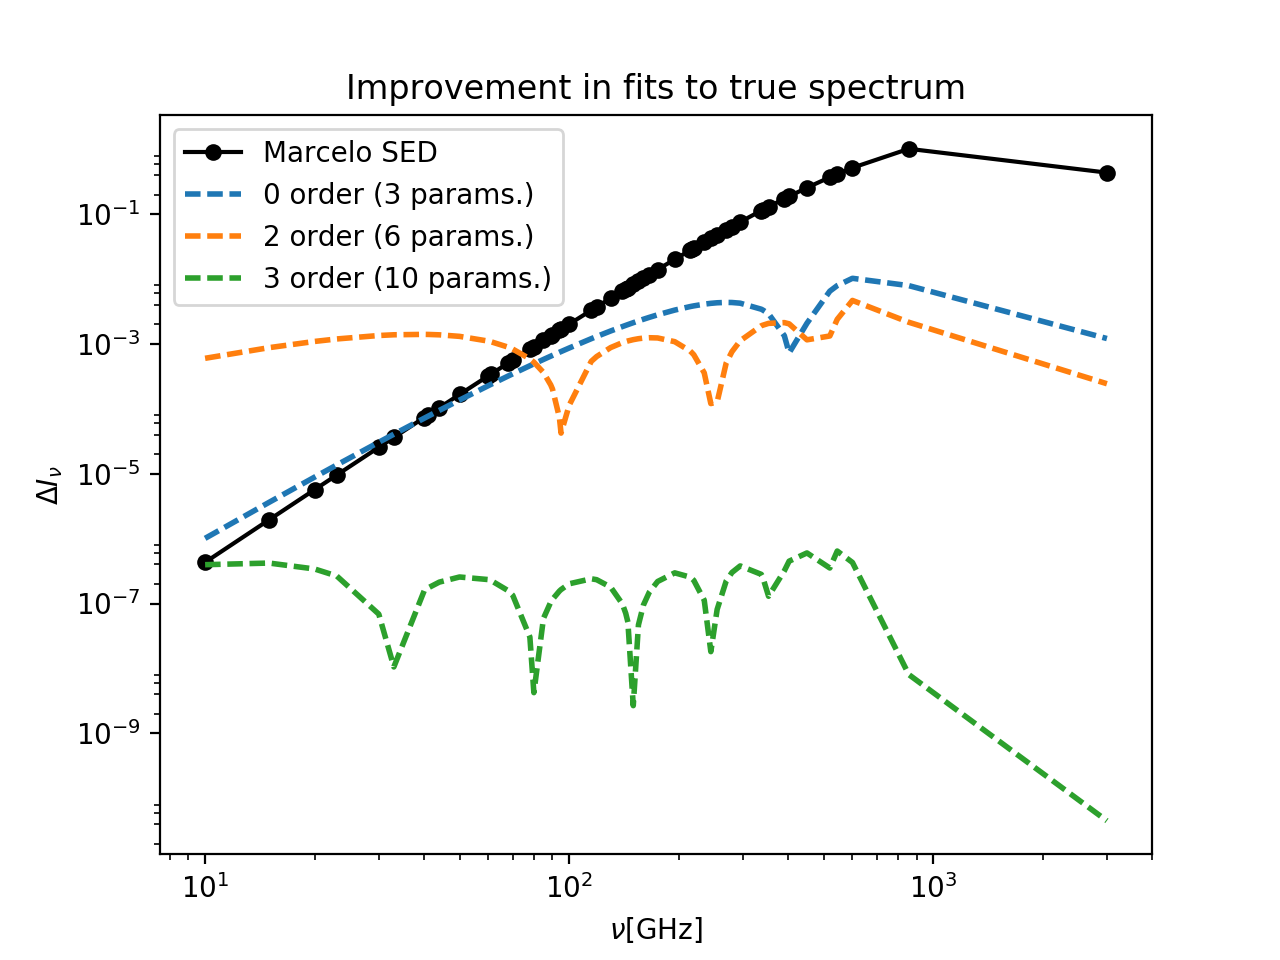

<IPython.core.display.Javascript object>


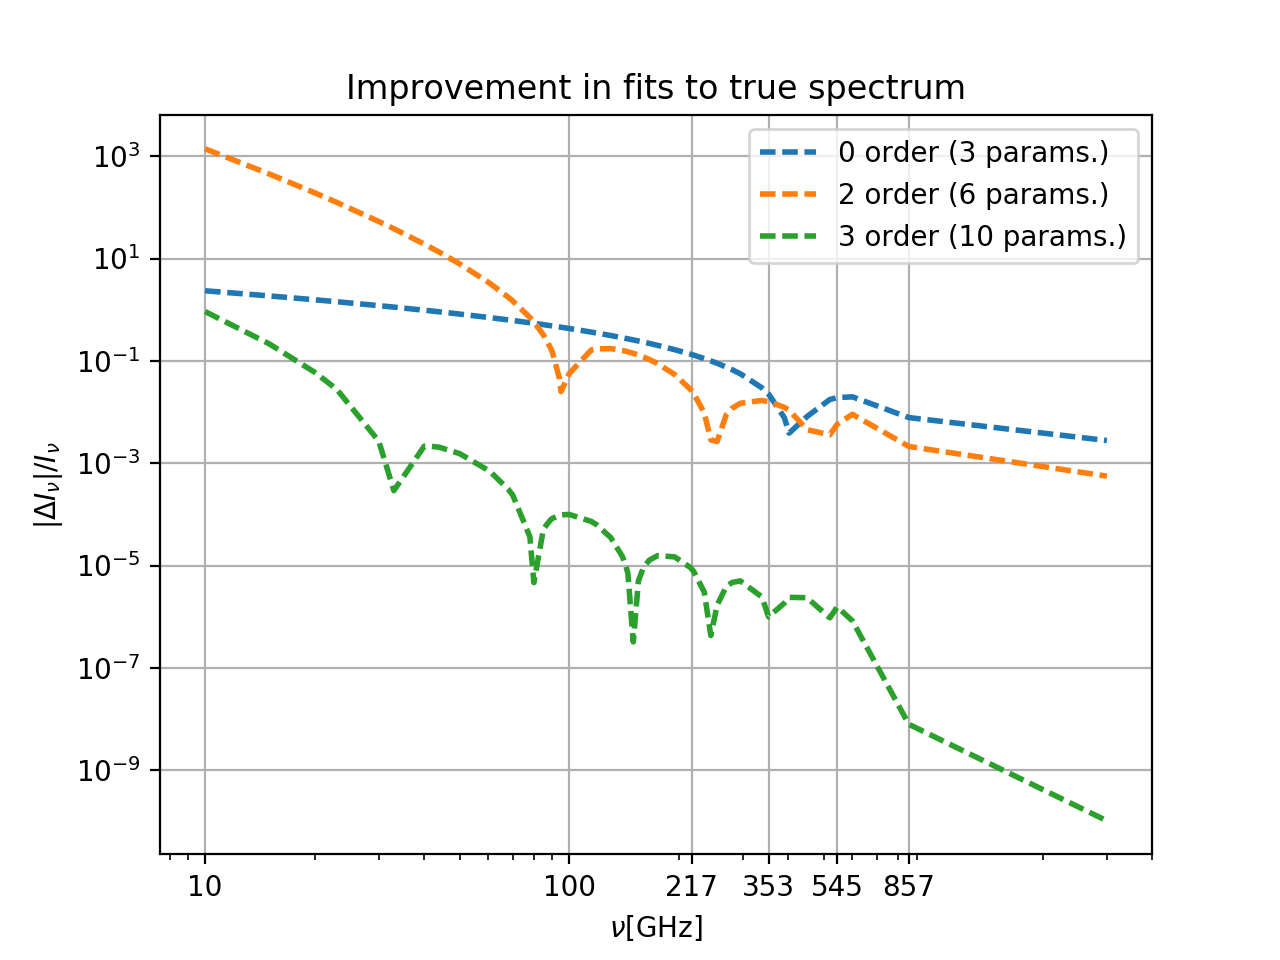

<IPython.core.display.Javascript object>


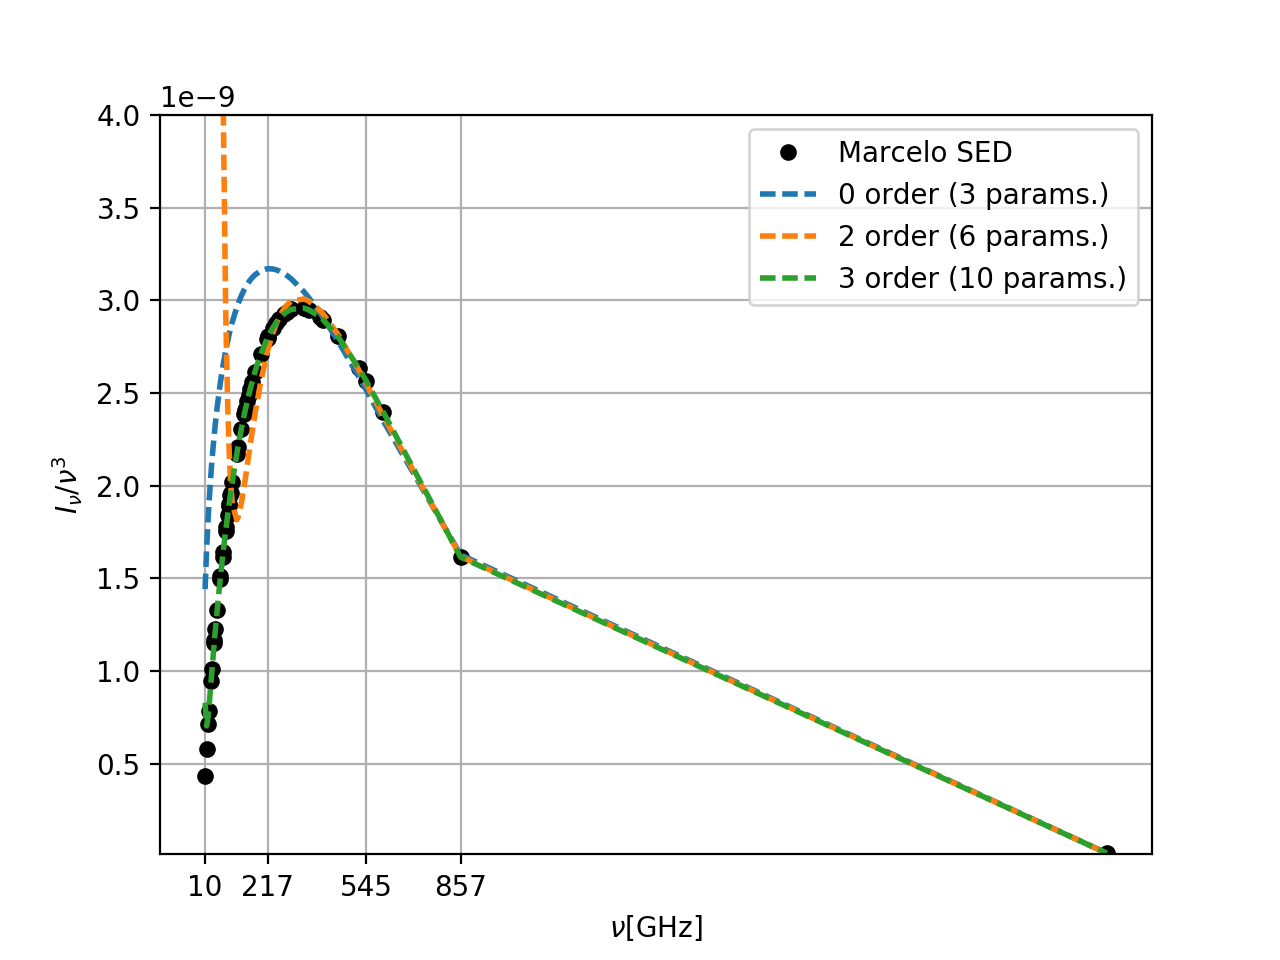

In [12]:
figure()
title("Improvement in fits to true spectrum")
plot(nu,Inu,"ko-",mec="none",label="Marcelo SED")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10])),"--",lw=2,label=pllabel)
semilogy()
loglog()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
legend(loc=0)
savefig(pathout + "improvement_in_fits_marcelo_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "improvement_in_fits_marcelo_sed.jpeg",dpi=150,bbox_inches="tight")


figure()
title("Improvement in fits to true spectrum")
pllabel="0 order (3 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.))/Inu,"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,abs(Inu-f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10]))/Inu,"--",lw=2,label=pllabel)
loglog()
ylabel(r"$|\Delta I_{\nu}|/I_{\nu}$")
xlabel(r"$\nu$[GHz]")
xticks([10,100,217,353,545,857],[10,100,217,353,545,857])
grid()
legend(loc=0)
savefig(pathout + "relative_error_with_taylor_order_marcelo_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "relative_error_with_taylor_order_marcelo_sed.jpeg",dpi=150,bbox_inches="tight")



figure()
sl=3.
title("")
plot(nu,Inu/(nu**sl),"ko",mec="none",label="Marcelo SED")
pllabel="0 order (3 params.)"
plot(nu,f_mbb(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2],p22=0., p23=0.,p33=0.,p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="2 order (6 params.)"
plot(nu,f_mbb(nu,T=fitp1[0],alpha=fitp1[1], A=fitp1[2],p22=fitp1[3], p23=fitp1[4],p33=fitp1[5],p222=0.,p223=0.,p233=0.,p333=0.,p2222=0.)/(nu**sl),"--",lw=2,label=pllabel)
pllabel="3 order (10 params.)"
plot(nu,f_mbb(nu,T=fitp2[0],alpha=fitp2[1], A=fitp2[2],p22=fitp2[3], p23=fitp2[4],p33=fitp2[5],p222=fitp2[6],p223=fitp2[7],p233=fitp2[8],p333=fitp2[9],p2222=fitp2[10])/(nu**sl),"--",lw=2,label=pllabel)
legend(loc=0)
ylabel(r"$I_{\nu}/ \nu^{3}$")
xlabel(r"$\nu$[GHz]")
grid()
#semilogx()
legend(loc=0)
xticks([10,217,545,857],[10,217,545,857])
ylim(1e-11,4e-9)
savefig(pathout + "inu_fit_with_taylor_order_marcelo_sed.pdf",dpi=150,bbox_inches="tight")
savefig(pathout + "inu_fit_with_taylor_order_marcelo_sed.jpeg",dpi=150,bbox_inches="tight")